In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


train_data = pd.read_csv('../data/balanced_train.csv')

test_data = pd.read_csv('../data/balanced_test.csv')


genre_columns = train_data.columns.drop(['Name', 'Description Tokenized'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_len = 40
batch_size = 16
epochs = 4
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MovieDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Description Tokenized']
        labels = self.data.iloc[idx][genre_columns]

        tokens = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': tokens['input_ids'][0],
            'attention_mask': tokens['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.float)
        }

loss_fn = nn.BCEWithLogitsLoss()

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model = model.train()
    losses = []

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses)

def evaluate(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            losses.append(loss.item())
    return np.mean(losses)

def predict(model, data_loader, device):
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())

    return np.array(predictions)

train_dataset = MovieDataset(train_data, tokenizer, max_len)
test_dataset = MovieDataset(test_data, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)
model.classifier = nn.Linear(model.config.hidden_size, 9).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss}")

    test_loss = evaluate(model, test_loader, loss_fn, device)
    print(f"Epoch {epoch + 1}/{epochs} | Test loss: {test_loss}")

predictions = predict(model, test_loader, device)
predictions_binary = (predictions > 0.5).astype(int)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/4 | Train loss: 0.5087013769894838
Epoch 1/4 | Test loss: 0.4426567334681749
Epoch 2/4 | Train loss: 0.4149539167061448
Epoch 2/4 | Test loss: 0.40646818093955517
Epoch 3/4 | Train loss: 0.3610733788460493
Epoch 3/4 | Test loss: 0.3818818923085928
Epoch 4/4 | Train loss: 0.3265436490997672
Epoch 4/4 | Test loss: 0.3739943981170654


In [8]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predictions_binary, target_names=genre_columns, zero_division=0)
print(report)

                         precision    recall  f1-score   support

                 Comedy       0.72      0.61      0.66       487
                  Crime       0.79      0.67      0.72       271
                  Drama       0.74      0.75      0.75       613
                Romance       0.62      0.51      0.56       270
   Action and Adventure       0.75      0.74      0.74       463
Documentary and History       0.73      0.58      0.64       172
   Family and Animation       0.75      0.66      0.70       275
     Fantasy and Sci-Fi       0.72      0.53      0.61       259
    Horror and Thriller       0.68      0.52      0.59       309

              micro avg       0.73      0.64      0.68      3119
              macro avg       0.72      0.62      0.66      3119
           weighted avg       0.73      0.64      0.68      3119
            samples avg       0.73      0.64      0.65      3119



In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc_pr_micro = average_precision_score(test_labels, predictions, average='micro')
auc_pr_macro = average_precision_score(test_labels, predictions, average='macro')
auc_pr_weighted = average_precision_score(test_labels, predictions, average='weighted')

auc_roc_micro = roc_auc_score(test_labels, predictions, average='micro')
auc_roc_macro = roc_auc_score(test_labels, predictions, average='macro')
auc_roc_weighted = roc_auc_score(test_labels, predictions, average='weighted')

data = {'AUC-PR': [auc_pr_micro, auc_pr_macro, auc_pr_weighted],
        'AUC-ROC': [auc_roc_micro, auc_roc_macro, auc_roc_weighted]}
index = ['micro', 'macro', 'weighted']
results = pd.DataFrame(data, index=index)

print(results)

            AUC-PR   AUC-ROC
micro     0.743356  0.880421
macro     0.723076  0.867596
weighted  0.736790  0.858336


In [9]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc


pr_curves = {}
roc_curves = {}
for i, genre in enumerate(genre_columns):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    fpr, tpr, _ = roc_curve(test_labels[:, i], predictions[:, i])
    pr_curves[genre] = (precision, recall)
    roc_curves[genre] = (fpr, tpr)
    
auc_pr = []
auc_roc = []
for i, genre in enumerate(genre_columns):
    ap = auc(pr_curves[genre][1], pr_curves[genre][0])
    ar = auc(roc_curves[genre][0], roc_curves[genre][1])
    auc_pr.append(ap)
    auc_roc.append(ar)

results = pd.DataFrame({'genre': genre_columns, 'AUC-PR': auc_pr, 'AUC-ROC': auc_roc})
print(results)


                     genre    AUC-PR   AUC-ROC
0                   Comedy  0.713164  0.811321
1                    Crime  0.797818  0.910251
2                    Drama  0.801379  0.828804
3                  Romance  0.588941  0.843718
4     Action and Adventure  0.814875  0.881098
5  Documentary and History  0.694420  0.919969
6     Family and Animation  0.739292  0.888062
7       Fantasy and Sci-Fi  0.700222  0.879413
8      Horror and Thriller  0.646175  0.845727


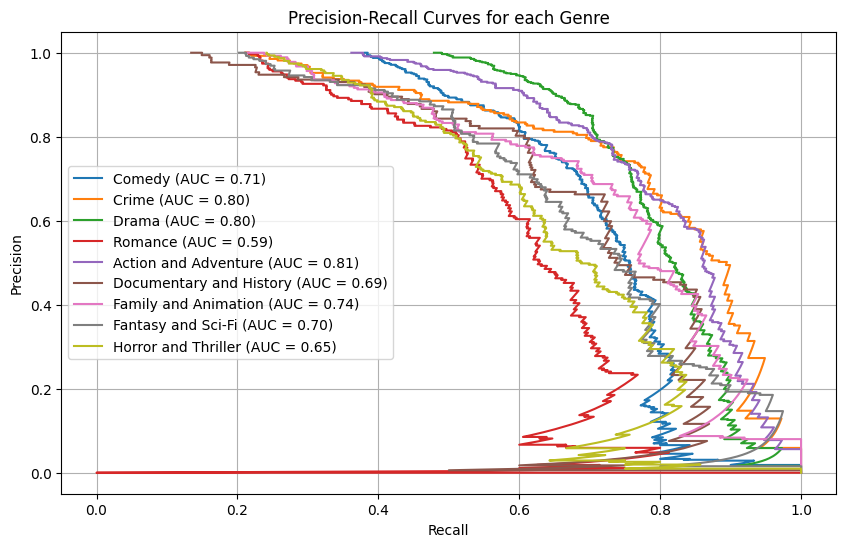

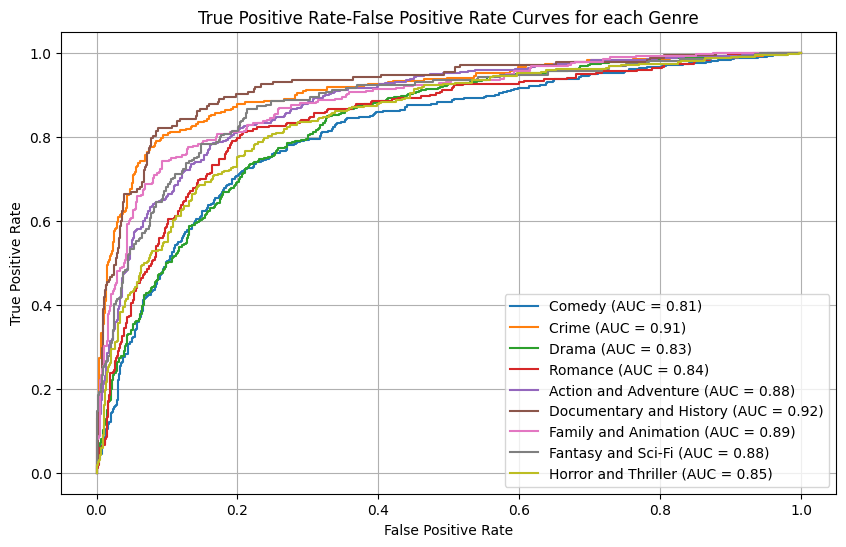

In [12]:
import matplotlib.pyplot as plt

def plot_curves(curves, curve_type, metric_name):
    plt.figure(figsize=(10, 6))
    for genre in curves.keys():
        x, y = curves[genre]
        if metric_name == 'AUC-PR':
            auc_value = auc(y, x)  # Use recall (y) as x and precision (x) as y
        else:
            auc_value = auc(x, y)  # Use FPR (x) as x and TPR (y) as y

        plt.plot(x, y, label=f'{genre} (AUC = {auc_value:.2f})')

    plt.xlabel(curve_type[0])
    plt.ylabel(curve_type[1])
    plt.title(f'{curve_type[1]}-{curve_type[0]} Curves for each Genre')
    plt.legend(loc='best')
    plt.grid()

plot_curves(pr_curves, ('Recall', 'Precision'), 'AUC-PR')
plt.show()

plot_curves(roc_curves, ('False Positive Rate', 'True Positive Rate'), 'AUC-ROC')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, f1_score


for i, genre in enumerate(genre_columns):
    cm = confusion_matrix(test_labels[:, i], predictions_binary[:, i])
    print(f'\nMatriz de confusão para {genre}:')
    print(cm)


Matriz de confusão para Comedy:
[[675 118]
 [189 298]]

Matriz de confusão para Crime:
[[961  48]
 [ 90 181]]

Matriz de confusão para Drama:
[[510 157]
 [155 458]]

Matriz de confusão para Romance:
[[926  84]
 [132 138]]

Matriz de confusão para Action and Adventure:
[[703 114]
 [122 341]]

Matriz de confusão para Documentary and History:
[[1071   37]
 [  73   99]]

Matriz de confusão para Family and Animation:
[[946  59]
 [ 94 181]]

Matriz de confusão para Fantasy and Sci-Fi:
[[966  55]
 [121 138]]

Matriz de confusão para Horror and Thriller:
[[896  75]
 [147 162]]


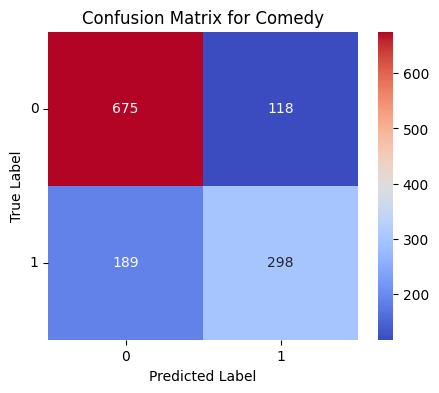

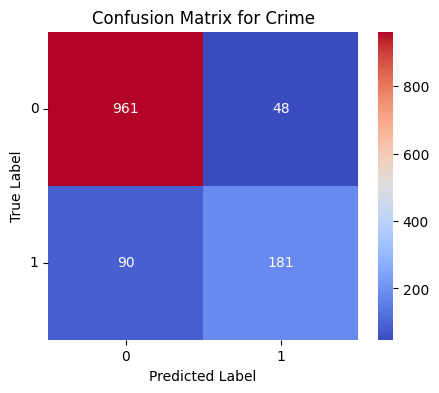

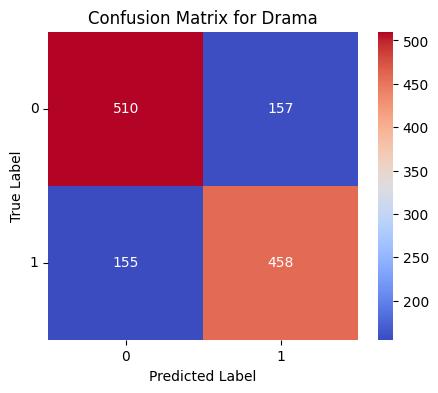

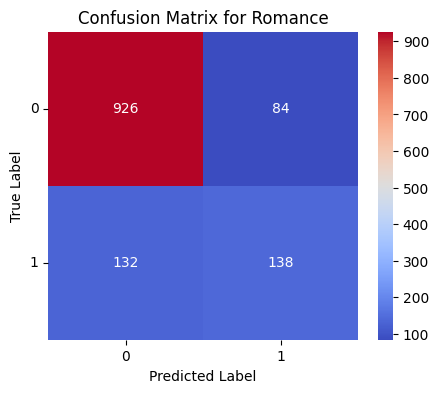

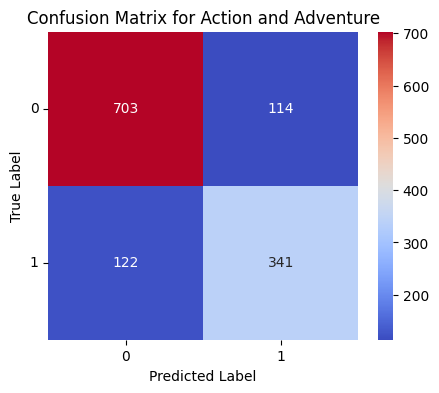

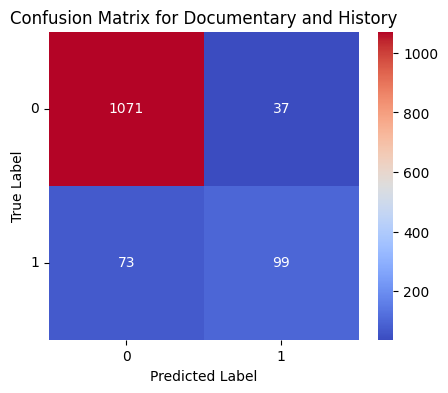

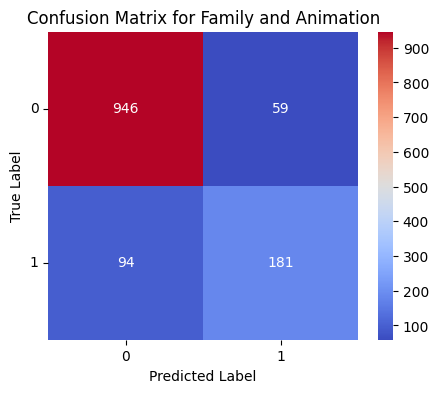

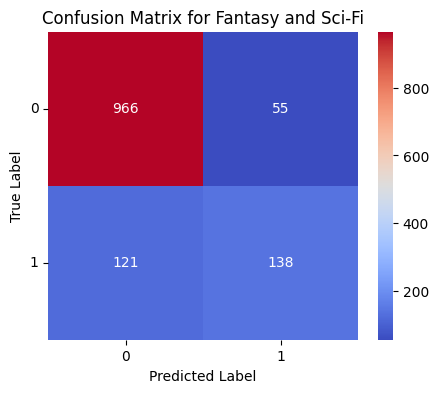

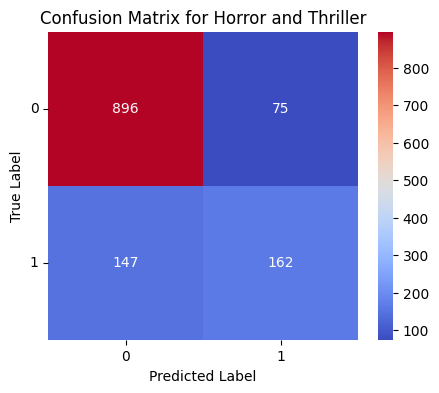

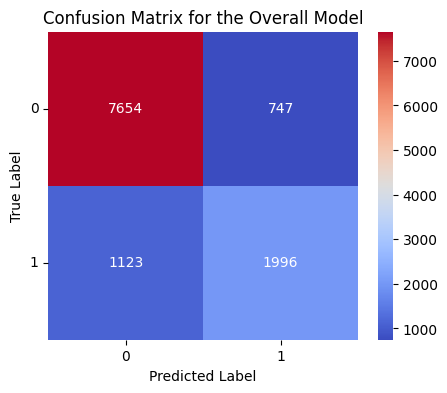

In [16]:
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.xticks(ticks=[0.5, 1.5], labels=[0, 1])
    plt.yticks(ticks=[0.5, 1.5], labels=[0, 1], rotation=0)
    plt.show()


cm_total = np.zeros((2, 2))
for i, genre in enumerate(genre_columns):
    cm = confusion_matrix(test_labels[:, i], predictions_binary[:, i])
    cm_total += cm
    plot_confusion_matrix(cm, f'Confusion Matrix for {genre}')

cm_total = cm_total.astype(int)

plot_confusion_matrix(cm_total, 'Confusion Matrix for the Overall Model')